# Несбалансированные выборки. Практическая работа

## Цель практической работы

Научиться обрабатывать несбалансированные данные и обучать модели машинного обучения на таких данных.

## Что входит в работу


1. Загрузить данные и провести разведочный анализ.
2. Разделить данные на обучающую и тестовую выборки.
3. Подготовить данные для моделирования.
4. Сбалансировать данные методом SMOTE и обучить модель машинного обучения.
5. Обучить модель машинного обучения с использованием весов классов и кросс-валидации.
6. Сравнить метрики качества четырёх моделей.




## Что оценивается 

- Выполнены все этапы работы.
- Не допущена утечка данных при разделении выборок и подготовке данных.
- Данные корректным образом сбалансированы.
- Модели не переобучены.


## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.


# Задача

Пусть у нас имеется некоторый набор данных `german_credit_data.csv` о заёмщиках банка:

* Age — возраст заёмщика.
* Sex — пол заёмщика.
* Job — тип работы заёмщика.
* Housing — тип жилья заёмщика.
* Saving accounts — объём средств на сберегательных счетах заёмщика.
* Checking account — объём средств на основном счёте заёмщика.
* Credit amount — размер кредита. 
* Duration — срок кредита (в месяцах).
* Purpose — цель кредита.
* Risk — таргет, допустил ли заёмщик просрочку платежей по кредиту.

Решите задачу классификации заёмщиков, чтобы банк умел заранее предсказывать просрочку платежей по кредиту. 



# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.model_selection import GridSearchCV

In [5]:
df = pd.read_csv('german_credit_data.csv')

In [6]:
# очень недобные названия
col_names = dict()
for col in df.columns:
    col_names[col] = col.replace(' ','_').lower() if ' ' in col.lower() else (col.lower()[3:] if 'num' in col.lower() else  col.lower())
df = df.rename(columns=col_names)

In [7]:
len(df)

1000

In [8]:
df.isna().sum()

age                   0
sex                   0
job                   0
housing               0
saving_accounts     183
checking_account    394
credit_amount         0
duration              0
purpose               0
risk                  0
dtype: int64

In [9]:
df.loc[df['checking_account'].isna() == True, 'checking_account'] = 'unknown'

In [10]:
df.loc[df['saving_accounts'].isna() == True, 'saving_accounts'] = 'unknown'

In [11]:
for col in df.columns:
    if df[col].dtype == 'O':
        continue

    res = stats.shapiro(df[col])
#     print(res[1] > 0.05)
    print(col,' - not normal dist' if res.pvalue <= 0.05  else '- normal dist')

age  - not normal dist
job  - not normal dist
credit_amount  - not normal dist
duration  - not normal dist


In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
obj_cols = []
for col in df.columns:
    if df[col].dtype == 'O':
        obj_cols.append(col)
        
obj_cols


['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose', 'risk']

In [14]:
classes = dict()
for col in obj_cols:

    encoder = LabelEncoder()
    new_name = col+'_le'
    df[new_name] = encoder.fit_transform(df[col])

    classes[col] = list(zip(df[col].value_counts().keys(), df[new_name].value_counts().keys()))
    for i in range(len(df[col].value_counts())):
        print(df[col].value_counts()[i] == df[new_name].value_counts().values[i])
    print(f'{col} checking done successfully')
#     random_index = random.randint(0, len(df[col].value_counts().keys()))
#     print(df[col].value_counts()[random_index])
#     print(df[new_name].value_counts()[random_index])
#     print(df[col].value_counts()[random_index] == df[new_name].value_counts()[random_index])
    
    df = df.drop(col, axis=1)

True
True
sex checking done successfully
True
True
True
housing checking done successfully
True
True
True
True
True
saving_accounts checking done successfully
True
True
True
True
checking_account checking done successfully
True
True
True
True
True
True
True
True
purpose checking done successfully
True
True
risk checking done successfully


In [15]:
classes

{'sex': [('male', 1), ('female', 0)],
 'housing': [('own', 1), ('rent', 2), ('free', 0)],
 'saving_accounts': [('little', 0),
  ('unknown', 4),
  ('moderate', 1),
  ('quite rich', 2),
  ('rich', 3)],
 'checking_account': [('unknown', 3),
  ('little', 0),
  ('moderate', 1),
  ('rich', 2)],
 'purpose': [('car', 1),
  ('radio/TV', 5),
  ('furniture/equipment', 4),
  ('business', 0),
  ('education', 3),
  ('repairs', 6),
  ('domestic appliances', 2),
  ('vacation/others', 7)],
 'risk': [('good', 1), ('bad', 0)]}

In [16]:
num_cols = []
for col in df.columns:
    if '_le' in col:
        continue
    num_cols.append(col)

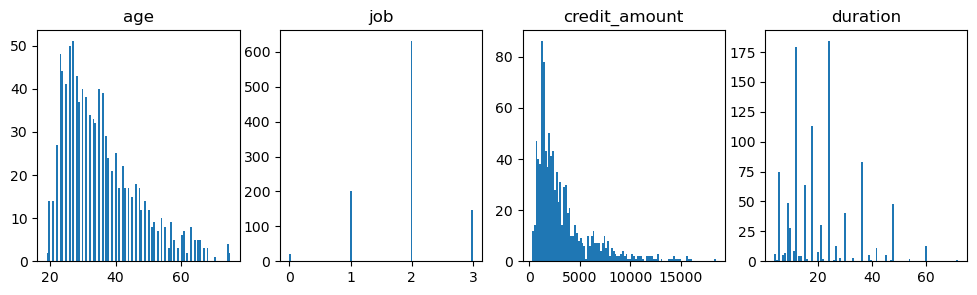

In [17]:
ax = plt.subplots(1, len(num_cols) , figsize=(12,3), )[1]
# i = 0
# k = 0
counter = 0
for col in num_cols:
    ax[counter].hist(df[col], bins=100)
    ax[counter].set_title(f'{col}')#, rotation=30)
    counter += 1


In [18]:
# больше всего заемщиков попадают в категорию 20-30 лет, "второй тип трудоустройства" - что бы это ни значило:), 
# занимают до 5000 у.е. и берут займы на год или два

In [19]:
obj_cols_le = []
for col in obj_cols:
    obj_cols_le.append(col+'_le')
obj_cols_le

['sex_le',
 'housing_le',
 'saving_accounts_le',
 'checking_account_le',
 'purpose_le',
 'risk_le']

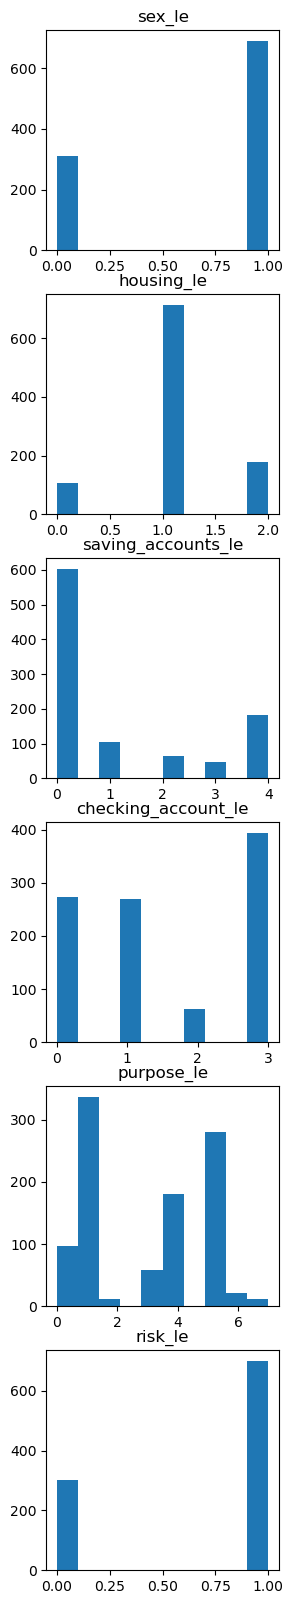

In [20]:
ax = plt.subplots( len(obj_cols_le) , 1, figsize=(3,20), )[1]
# i = 0
# k = 0
counter = 0
for col in obj_cols_le:
    ax[counter].hist(df[col])
    ax[counter].set_title(f'{col}')#, rotation=30)
    counter += 1

In [21]:
classes['purpose'][0:3]

[('car', 1), ('radio/TV', 5), ('furniture/equipment', 4)]

In [22]:
df.purpose_le.value_counts()

1    337
5    280
4    181
0     97
3     59
6     22
2     12
7     12
Name: purpose_le, dtype: int64

In [23]:
classes

{'sex': [('male', 1), ('female', 0)],
 'housing': [('own', 1), ('rent', 2), ('free', 0)],
 'saving_accounts': [('little', 0),
  ('unknown', 4),
  ('moderate', 1),
  ('quite rich', 2),
  ('rich', 3)],
 'checking_account': [('unknown', 3),
  ('little', 0),
  ('moderate', 1),
  ('rich', 2)],
 'purpose': [('car', 1),
  ('radio/TV', 5),
  ('furniture/equipment', 4),
  ('business', 0),
  ('education', 3),
  ('repairs', 6),
  ('domestic appliances', 2),
  ('vacation/others', 7)],
 'risk': [('good', 1), ('bad', 0)]}

In [24]:
# популярнее всего кредиты на машину, ТВ и мебель, жилье в собственности (неплохо!), , сами займы оформляются на мужчин, на 
# счетах сбережений либо мало, либо они в другом банке - т.к. много "неизвестных" - иначе, предположительно банк бы не оставил 
# это поле пустым - но это все же догадка

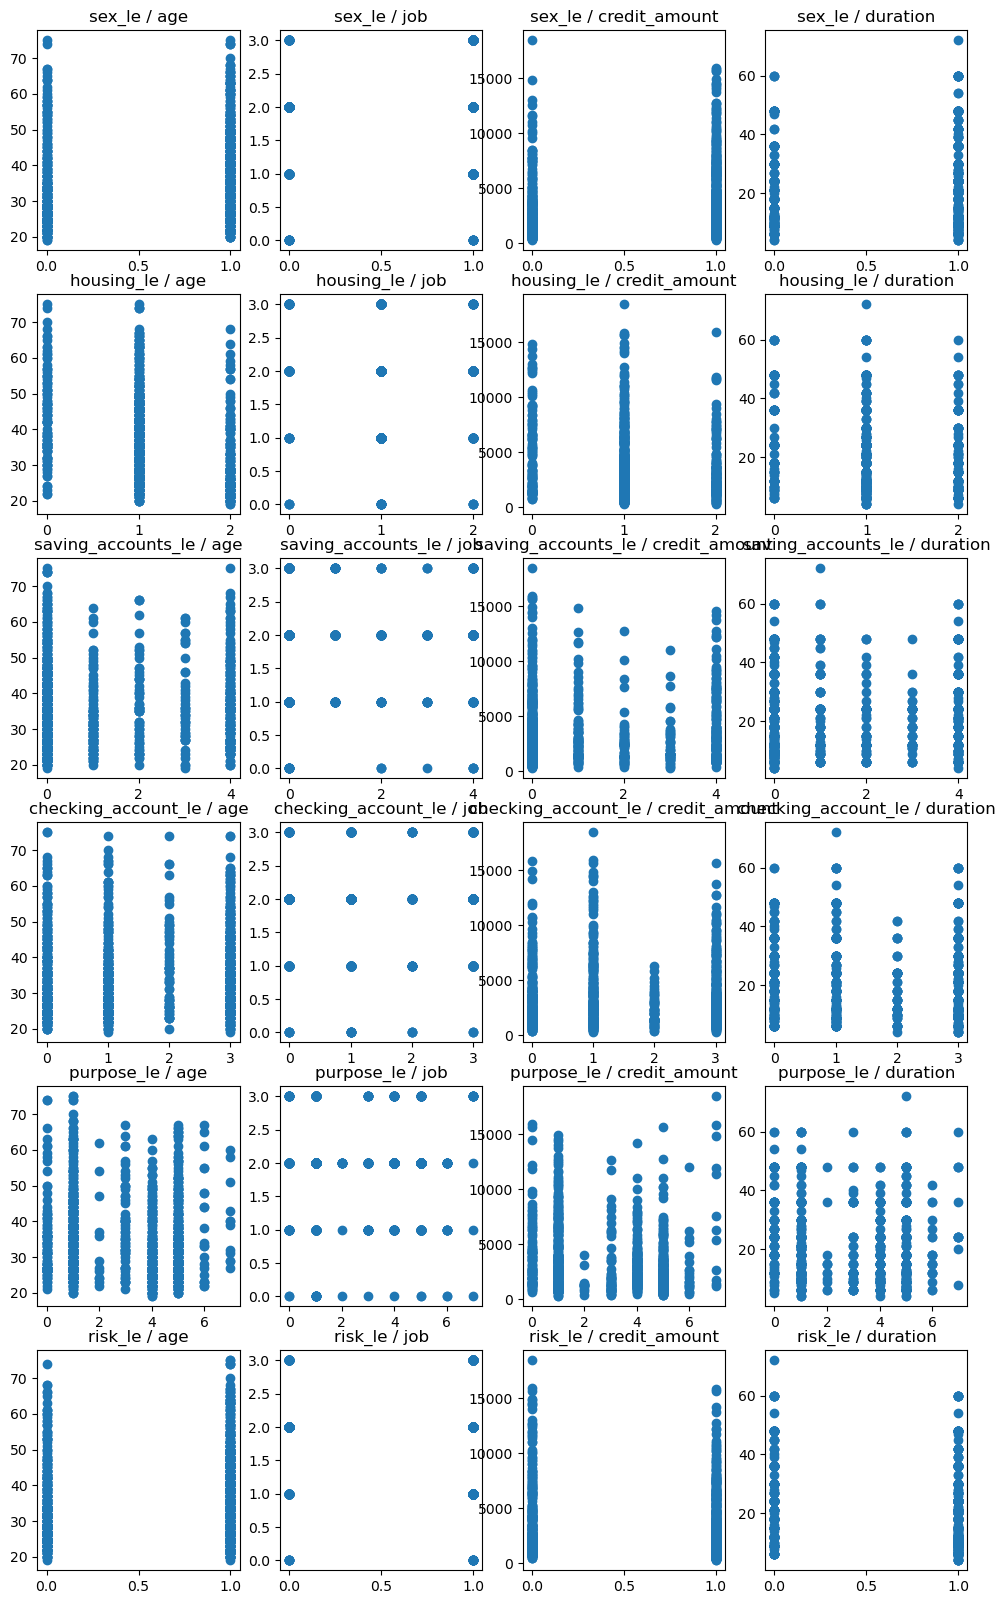

In [25]:
i = 0
k = 0
ax = plt.subplots( len(obj_cols_le) , len(num_cols) , figsize=(12,20), )[1]

for o_col in obj_cols_le:
    k = 0
    for n_col in num_cols:
        ax[i][k].scatter(df[o_col], df[n_col])
        ax[i][k].set_title(f'{o_col} / {n_col}')
        k += 1
    i += 1

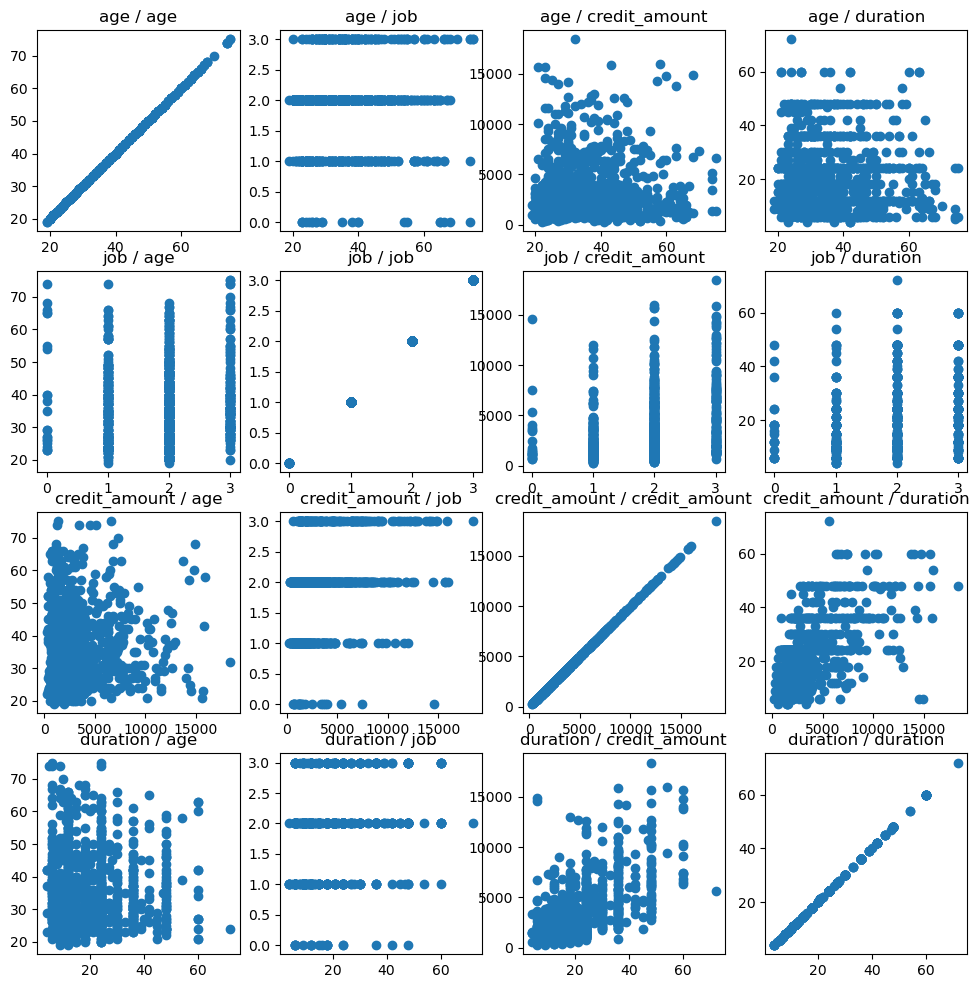

In [26]:
i = 0
k = 0
ax = plt.subplots( len(num_cols) , len(num_cols) , figsize=(12,12), )[1]

for o_col in num_cols:
    k = 0
    for n_col in num_cols:
        ax[i][k].scatter(df[o_col], df[n_col])
        ax[i][k].set_title(f'{o_col} / {n_col}')
        k += 1
    i += 1

In [27]:
import seaborn as sns

<AxesSubplot:>

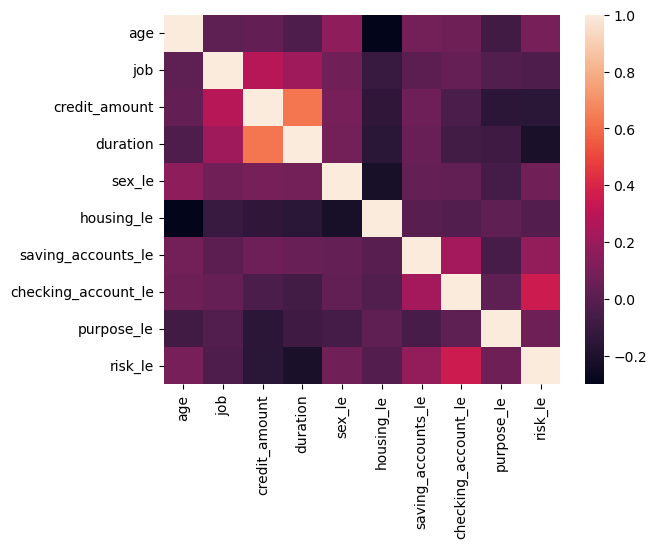

In [28]:
sns.heatmap(df.corr())

In [29]:
# каких то явных закономерностей между фичами замечено не было, разве что чем больше кредит, 
# тем чаще его берут надолго, но тут, в общем то, и график, думаю, не был нужен:)

# Задание 2

Разделите датасет на обучающую и тестовую выборки в пропорции 80:20. Разделение должно быть стратифицированным по таргету Risk.

В этом и следующих заданиях используйте random_state = 1.

In [30]:
df_train, df_test = train_test_split(df, stratify=df['risk_le'], test_size=0.2, random_state=1)

# Задание 3

Проведите этап очистки и подготовки данных (data preparation) и подготовьте данные к моделированию.

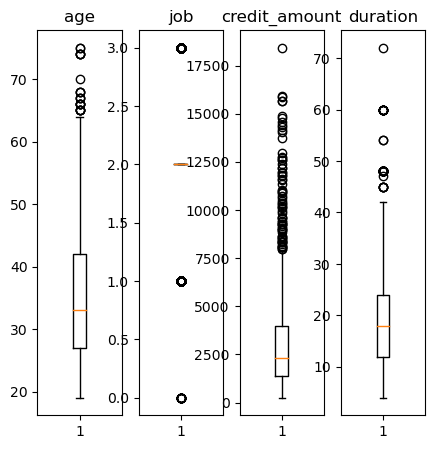

In [31]:
ax = plt.subplots( 1 , len(num_cols), figsize=(5,5), )[1]
# i = 0
# k = 0
counter = 0
for col in num_cols:
    ax[counter].boxplot(df[col])
    ax[counter].set_title(f'{col}')#, rotation=30)
    counter += 1

In [32]:
def calculate_iqr_boundaries(series):
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25

    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [33]:
def bounds_f(x_train):
    bounds = []
    bounds_d = dict()
    for col in x_train.columns:
        bounds_d[col] = calculate_iqr_boundaries(x_train[col])

    return bounds_d

In [34]:
bounds = bounds_f(df_train)
bounds

{'age': (4.5, 64.5),
 'job': (2.0, 2.0),
 'credit_amount': (-2412.25, 7717.75),
 'duration': (-6.0, 42.0),
 'sex_le': (-1.5, 2.5),
 'housing_le': (1.0, 1.0),
 'saving_accounts_le': (-3.0, 5.0),
 'checking_account_le': (-4.5, 7.5),
 'purpose_le': (-5.0, 11.0),
 'risk_le': (-1.5, 2.5)}

In [35]:
len(df[df['credit_amount'] > bounds['credit_amount'][1]])

80

In [36]:
# не похоже на ошибку, но все же выброс - убираем
# по поводу других колонок в общем не было такого вопроса


In [37]:
df_train.loc[df_train['credit_amount'] > bounds['credit_amount'][1], 'credit_amount'] = bounds['credit_amount'][1]

In [38]:
len(df[df['age'] > bounds['age'][1]])

23

In [39]:
len(df[df['duration'] > bounds['duration'][1]])

70

In [40]:
df_train.loc[df_train['duration'] > bounds['duration'][1], 'duration'] = bounds['duration'][1]

In [41]:
scaler = MinMaxScaler()


In [42]:
num_cols.pop(1)
# df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)

'job'

In [43]:
df_train_scaled = df_train.copy()

df_train_scaled[num_cols] = scaler.fit_transform(df_train[num_cols]) 

# Задание 4

Сбалансируйте обучающую выборку методом SMOTE и обучите модель RandomForestClassifier. Подберите оптимальные гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [44]:
df_train_scaled.drop('risk_le', axis=1).columns

Index(['age', 'job', 'credit_amount', 'duration', 'sex_le', 'housing_le',
       'saving_accounts_le', 'checking_account_le', 'purpose_le'],
      dtype='object')

In [45]:
smote = SMOTE(random_state=1, k_neighbors=2)

features = df_train_scaled.drop('risk_le', axis=1).columns
target = 'risk_le'

x_train, y_train = smote.fit_resample(df_train_scaled[features], df_train_scaled[target])

In [46]:
rf = RandomForestClassifier()#class_weight='balanced')

In [47]:


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')

grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.8770966198979592


In [48]:
df_test.loc[df_test['credit_amount'] > bounds['credit_amount'][1], 'credit_amount'] = bounds['credit_amount'][1]
df_test.loc[df_test['duration'] > bounds['duration'][1], 'duration'] = bounds['duration'][1]

In [49]:
df_test_scaled = df_test.copy()

df_test_scaled[num_cols] = scaler.transform(df_test[num_cols]) 

In [50]:
rf_smote_ready = RandomForestClassifier(n_estimators= 300 , max_depth= None, min_samples_split=2 , min_samples_leaf= 1)
rf_smote_ready.fit(x_train, y_train)
preds = rf_smote_ready.predict(df_test_scaled.drop('risk_le', axis=1))
result = roc_auc_score(df_test_scaled['risk_le'], preds)

In [51]:
result

0.6702380952380953

# Задание 5

Обучите модель RandomForestClassifier с использованием весов классов. Подберите оптимальные веса и гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [52]:
rf_balanced = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample'],
}

grid_search_balanced = GridSearchCV(estimator=rf_balanced, param_grid=param_grid, cv=5, scoring='roc_auc')

grid_search.fit(df_train_scaled.drop('risk_le', axis=1), df_train_scaled['risk_le'])

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.7648809523809526


In [53]:
df_test_scaled = df_test.copy()

df_test_scaled[num_cols] = scaler.transform(df_test[num_cols]) 

In [54]:
balanced = ['balanced', 'balanced_subsample']
result_overall = []
for pos in balanced:
    rf_balanced = RandomForestClassifier(
        n_estimators= 300 , 
        max_depth= 10, 
        min_samples_split=5 , 
        min_samples_leaf= 1, 
        class_weight=pos,
    )


    rf_balanced.fit(df_train_scaled.drop('risk_le', axis=1), df_train_scaled['risk_le'])
    preds = rf_balanced.predict(df_test_scaled.drop('risk_le', axis=1))
    result = roc_auc_score(df_test_scaled['risk_le'], preds)
    result_overall.append(f'{pos} res is {result}')
result_overall

['balanced res is 0.7000000000000001',
 'balanced_subsample res is 0.6833333333333333']